# SPINN NF2 inputdata generation
> save using pickle

In [ ]:
from zpinn.lowloumag import LowLouMag

In [ ]:
nx = 64
ny = 64
nz = 64

In [ ]:
b = LowLouMag(resolutions=[nx, ny, nz])
b.calculate()

UniformGrid (0x7f784e3fe020)
  N Cells:      250047
  N Points:     262144
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   64, 64, 64
  Spacing:      3.175e-02, 3.175e-02, 3.175e-02
  N Arrays:     3

In [ ]:
b.bottom

PolyData (0x7f779d61de40)
  N Cells:    3969
  N Points:   4096
  N Strips:   0
  X Bounds:   -1.000e+00, 1.000e+00
  Y Bounds:   -1.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5

In [ ]:
b_bottom = b.b_bottom
b_bottom.shape

(64, 64, 3)

In [ ]:
b_norm = 100

In [ ]:
import matplotlib.pyplot as plt

<matplotlib.image.AxesImage>

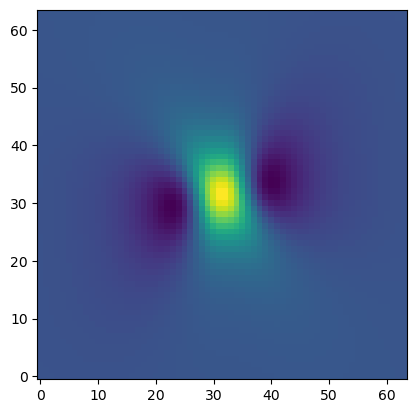

In [ ]:
plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower')

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

In [ ]:
from zpinn.pinn_nf2_cleanup import PotentialModel, create_coordinates

In [ ]:
bottom_values = b_bottom.reshape(-1, 3)
bottom_bounds = (0, nx-1, 0, ny-1, 0, 0)
bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)
b_n = torch.tensor(bottom_values[:, 2], dtype=torch.float64)
r_p = torch.tensor(bottom_coords, dtype=torch.float64)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

In [ ]:
top_bounds = (0, nx-1, 0, ny-1, nz-1, nz-1)
lateral_bounds_1 = (0, 0, 0, ny-1, 0, nz-1)
lateral_bounds_2 = (nx-1, nx-1, 0, ny-1, 0, nz-1)
lateral_bounds_3 = (0, nx-1, 0, 0, 0, nz-1)
lateral_bounds_4 = (0, nx-1, ny-1, ny-1, 0, nz-1)

top_coords = create_coordinates(top_bounds).reshape(-1, 3)
lateral_coords_1 = create_coordinates(lateral_bounds_1).reshape(-1, 3)
lateral_coords_2 = create_coordinates(lateral_bounds_2).reshape(-1, 3)
lateral_coords_3 = create_coordinates(lateral_bounds_3).reshape(-1, 3)
lateral_coords_4 = create_coordinates(lateral_bounds_4).reshape(-1, 3)

In [ ]:
top_lateral_coordinates = [top_coords,
                           lateral_coords_1,
                           lateral_coords_2,
                           lateral_coords_3,
                           lateral_coords_4]

In [ ]:
pf_fields = []
pf_coords = []
for r_coords in top_lateral_coordinates:
    r_coords = torch.tensor(r_coords, dtype=torch.float64)
    # pf_batch_size = int(np.prod(r_coords.shape[:-1]) // 500)
    pf_batch_size = int(1024 * 512 ** 2 / (nx*ny))

    fields = []
    for r, in tqdm(DataLoader(TensorDataset(r_coords), batch_size=pf_batch_size, num_workers=2),
                        desc='Potential Boundary'):
        r = r.to(device).requires_grad_(True)
        p_batch = model(r)
        b_p = -1 * torch.autograd.grad(p_batch, r, torch.ones_like(p_batch), retain_graph=True, create_graph=True)[0]
        fields += [b_p.clone().detach().cpu().numpy()]
    pf_fields += [np.concatenate(fields)]
    pf_coords += [r_coords.clone().detach().cpu().numpy()]

Potential Boundary: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


In [ ]:
bp_top = pf_fields[0].reshape(nx, ny, 3) 
bp_lateral_1 = pf_fields[1].reshape(ny, nz, 3)
bp_lateral_2 = pf_fields[2].reshape(ny, nz, 3) 
bp_lateral_3 = pf_fields[3].reshape(nx, nz, 3) 
bp_lateral_4 = pf_fields[4].reshape(nx, nz, 3) 

In [ ]:
b_bottom = b_bottom / b_norm 
bp_top = bp_top / b_norm
bp_lateral_1 = bp_lateral_1 / b_norm
bp_lateral_2 = bp_lateral_2 / b_norm
bp_lateral_3 = bp_lateral_3 / b_norm 
bp_lateral_4 = bp_lateral_4 / b_norm

In [ ]:
import pickle

In [ ]:
with open("bv.pickle","wb") as f:
    pickle.dump(b.grid['B'], f)

with open("b_bottom.pickle","wb") as f:
    pickle.dump(b_bottom, f)

with open("bp_top.pickle","wb") as f:
    pickle.dump(bp_top, f)

with open("bp_lateral_1.pickle","wb") as f:
    pickle.dump(bp_lateral_1, f)

with open("bp_lateral_2.pickle","wb") as f:
    pickle.dump(bp_lateral_2, f)

with open("bp_lateral_3.pickle","wb") as f:
    pickle.dump(bp_lateral_3, f)

with open("bp_lateral_4.pickle","wb") as f:
    pickle.dump(bp_lateral_4, f)

In [ ]:
b.grid['B'].shape

(262144, 3)

In [ ]:
b_bottom.shape, bp_top.shape, bp_lateral_1.shape, bp_lateral_2.shape, bp_lateral_3.shape, bp_lateral_4.shape

((64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3))

In [ ]:
with open("bv.pickle","rb") as f:
    bv = pickle.load(f)

with open("b_bottom.pickle","rb") as f:
    b_bottom = pickle.load(f)

with open("bp_top.pickle","rb") as f:
    bp_top = pickle.load(f)

with open("bp_lateral_1.pickle","rb") as f:
    bp_lateral_1 = pickle.load(f)

with open("bp_lateral_2.pickle","rb") as f:
    bp_lateral_2 = pickle.load(f)

with open("bp_lateral_3.pickle","rb") as f:
    bp_lateral_3 = pickle.load(f)

with open("bp_lateral_4.pickle","rb") as f:
    bp_lateral_4 = pickle.load(f)

In [ ]:
bv.shape

(262144, 3)

In [ ]:
b_bottom.shape, bp_top.shape, bp_lateral_1.shape, bp_lateral_2.shape, bp_lateral_3.shape, bp_lateral_4.shape

((64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3))